### This notebook provides visualization for predictions.
### Feel free to change hard coded paths, such as project root, dataset root and prediction file path.

In [1]:
cd '/home/linghao/PycharmProjects/disprcnn-release'

/home/linghao/PycharmProjects/disprcnn-release


In [2]:
import matplotlib.pyplot as plt
import torch
from disprcnn.modeling.roi_heads.mask_head.inference import Masker
from disprcnn.data.datasets.kitti_car import KITTIObjectDatasetCar
from PIL import Image
import numpy as np
from disprcnn.modeling.psmnet.inference import DisparityMapProcessor
import cv2
from matplotlib import collections as mc

In [3]:
prediction_pth = 'models/kitti/car/vob/rcnn/inference/kitti_val_vob_car/predictions.pth'
masker_thresh = 0.5

In [4]:
masker = Masker(masker_thresh)
ds = KITTIObjectDatasetCar('data/kitti', 'val',shape_prior_base='vob',remove_ignore=False)
predictions=torch.load(prediction_pth,'cpu')
left_preds=predictions['left']
right_preds=predictions['right']

In [9]:
def visualize(idx):
    print('imgid',ds.ids[idx])
    imgs, targets, _ = ds[idx]
    leftimg, rightimg = imgs['left'], imgs['right']
    left_target=targets['left']
    right_target=targets['right']
    calib=left_target.get_field('calib')

    left_pred=left_preds[idx]
    right_pred=right_preds[idx]
    
    assert left_pred.size==leftimg.size
    if len(left_pred)==0:
        print('0 cars detected.')
        return
    plt.figure(figsize=(20,20))
    plt.rcParams['figure.dpi'] = 300
    plt.title('2d')
    plt.axis('off')
    leftimg=np.array(leftimg)
    predcorners=left_pred.get_field('box3d').convert('corners').bbox_3d.view(-1,8,3)
    corners=calib.calib.corners3d_to_img_boxes(predcorners)[1].numpy()

    for ci,c in enumerate(corners):
        pts = np.array([c[[0, 1, 2, 3, 0, 4, 7, 3]]])
        seg=mc.LineCollection(pts,colors='lime',linewidths=2,)
        plt.gca().add_collection(seg)
        pts = np.array(
            [c[[5, 4, 7, 6, 5, 1, 2, 6]]])
        seg=mc.LineCollection(pts,colors='lime',linewidths=2)
        plt.gca().add_collection(seg)
    plt.imshow(leftimg)
    plt.show()

    plt.figure(figsize=(20,20))
    plt.axis('off')
    plt.title('mask')
    mask=left_pred.get_field('mask')
    mask=masker([mask], [left_pred])[0].squeeze()
    if mask.ndimension()==3:
        mask=mask.sum(dim=0).clamp(max=1)
    plt.imshow(mask)
    plt.show()
    
    plt.figure(figsize=(20,20))
    plt.title('disparity')
    plt.axis('off')
    disp_pred=DisparityMapProcessor()(left_pred,right_pred).data*mask.float()
    plt.imshow(disp_pred,'jet');
    plt.show()
    
    plt.close('all')

imgid 000006


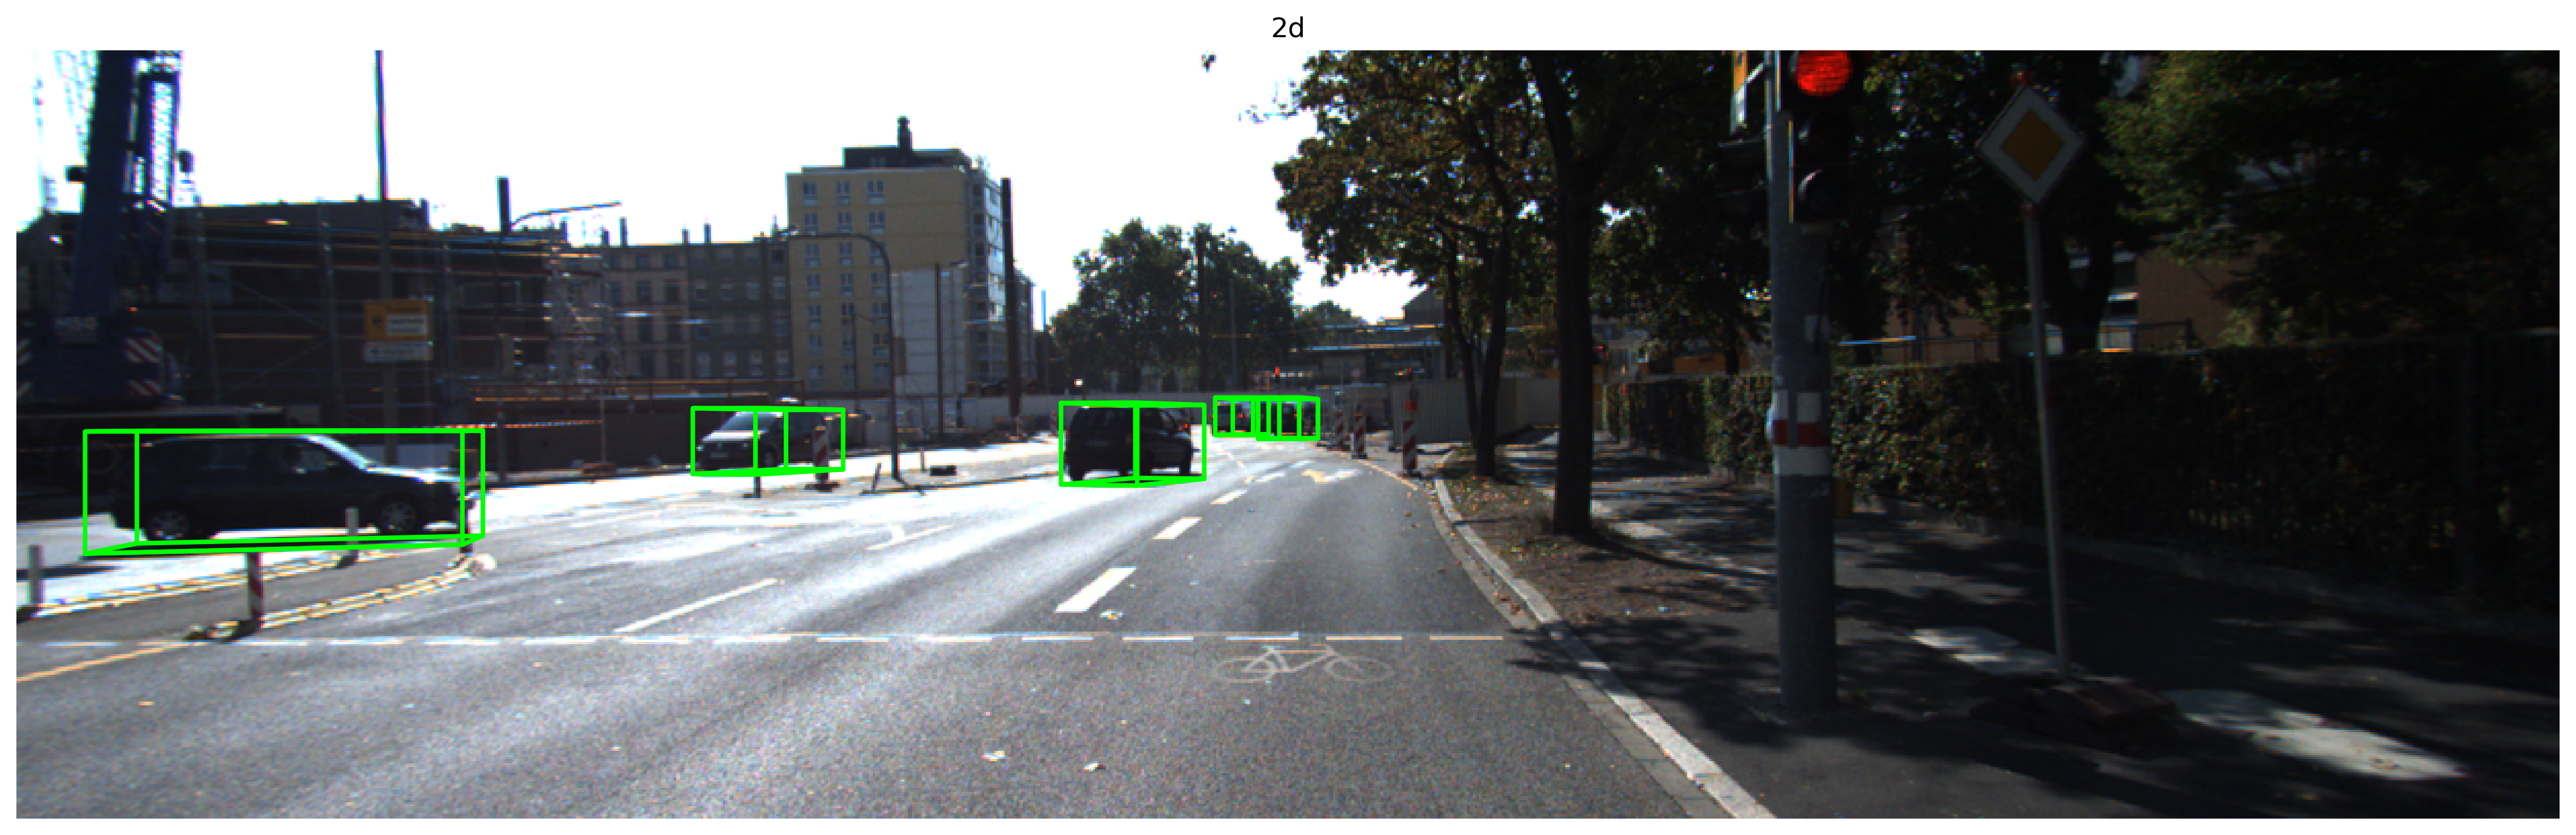

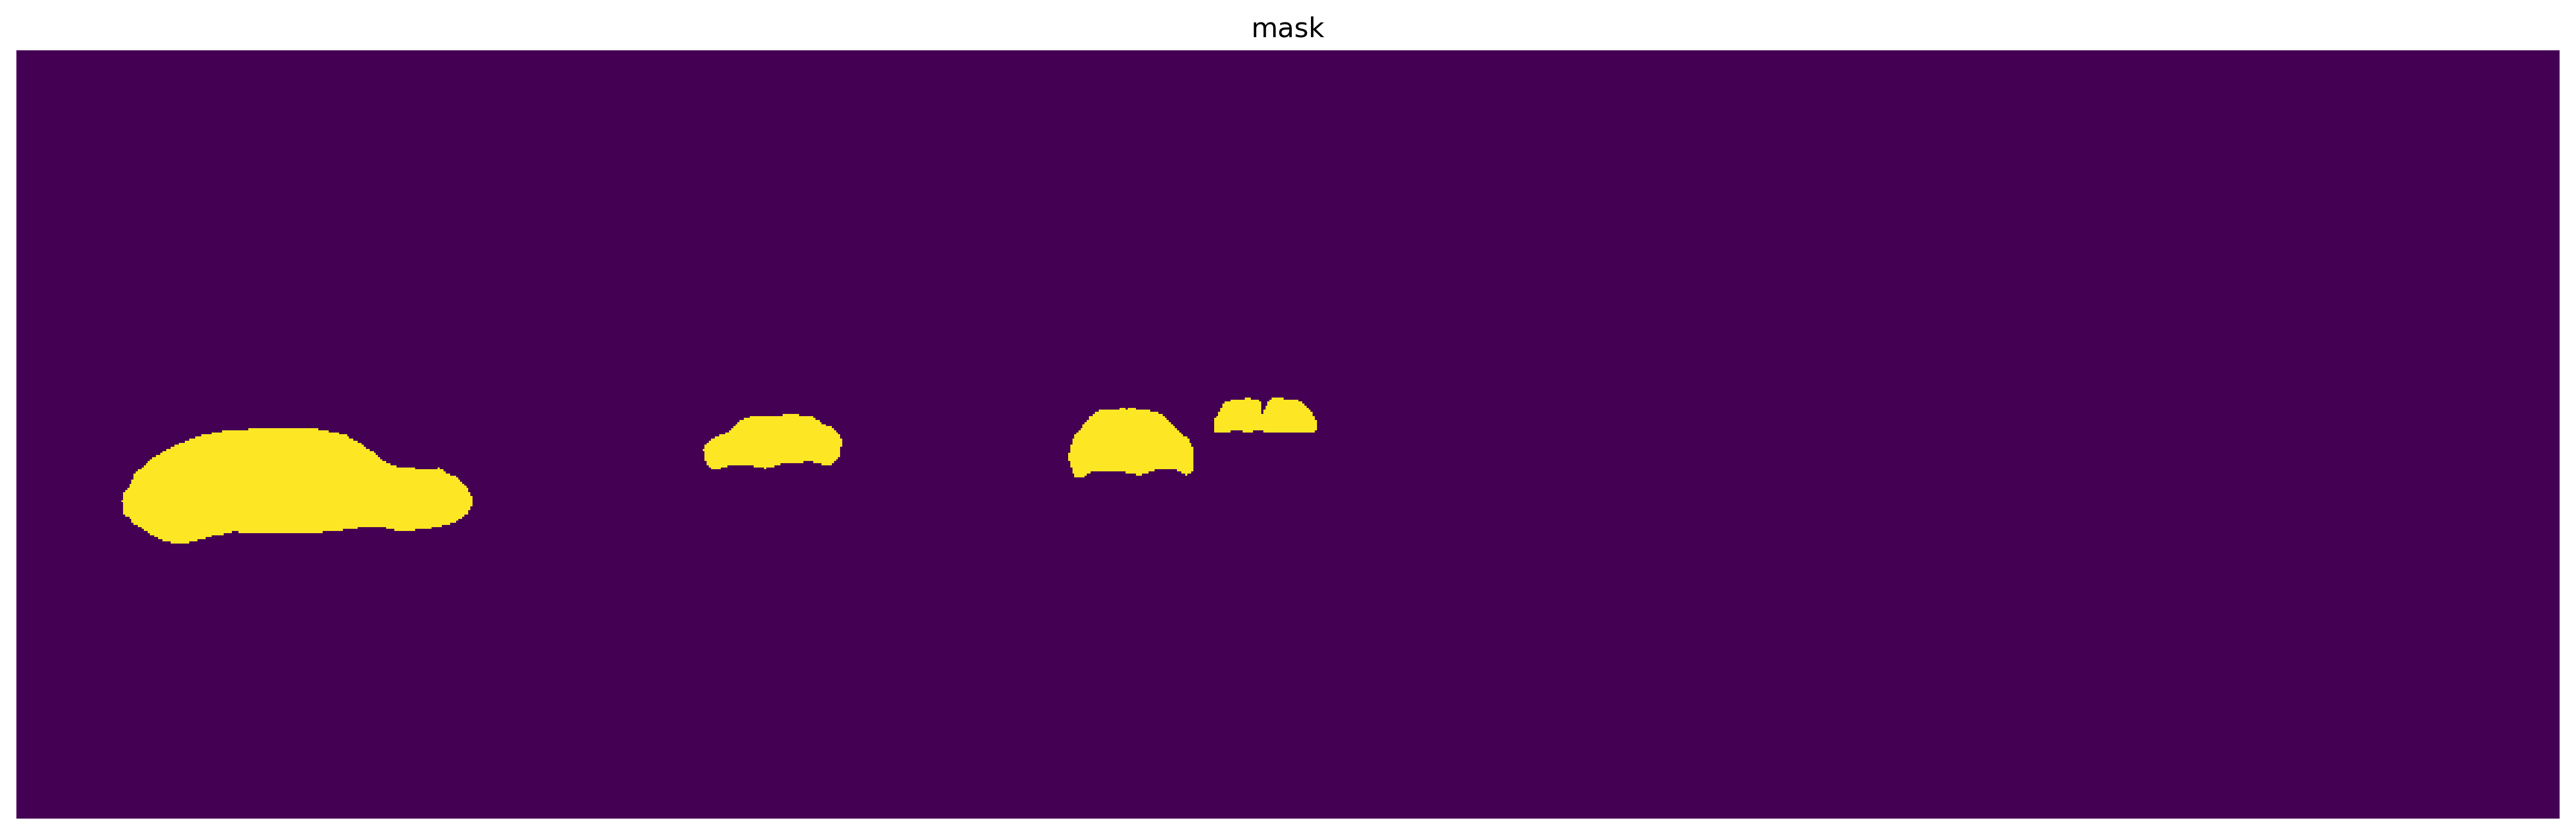

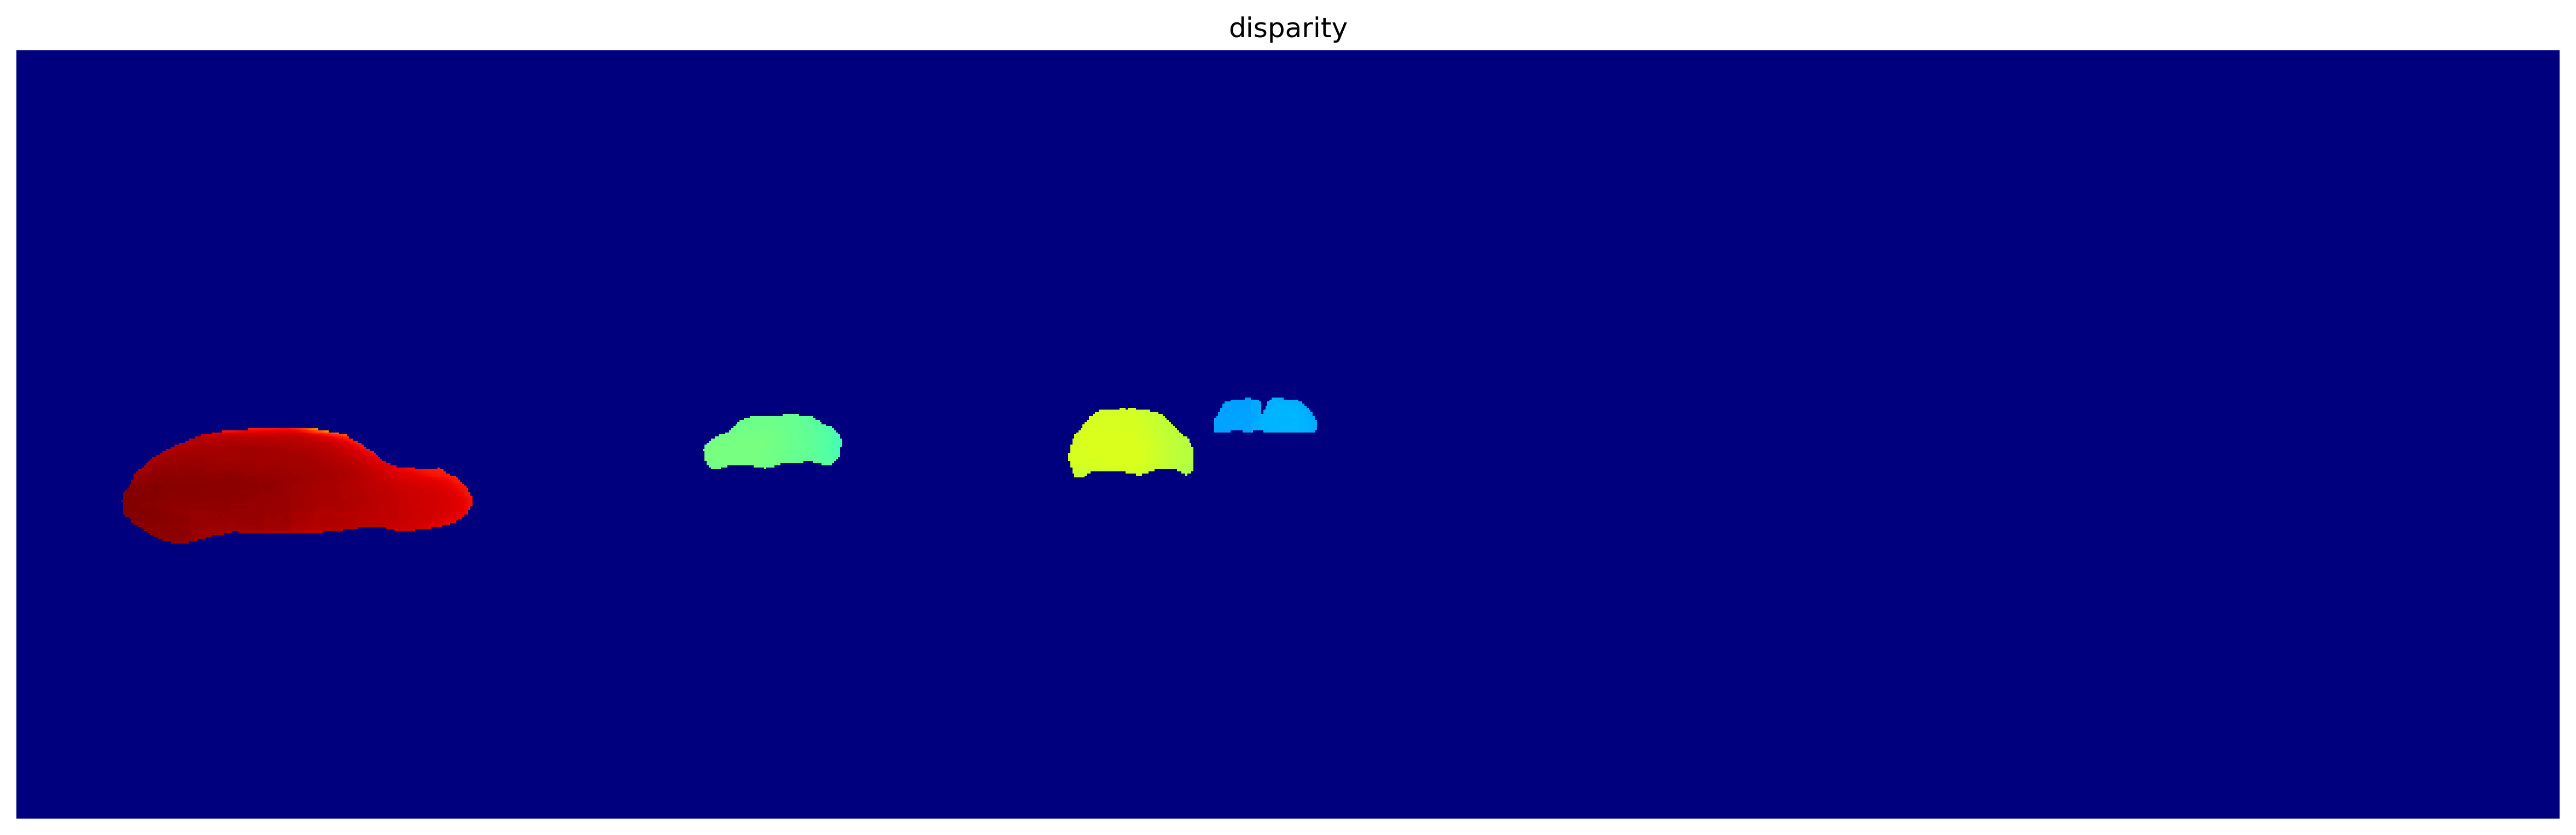

In [10]:
visualize(4)